In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
batch_size = 64

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=train_transform
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=test_transform
)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=8)

100%|██████████| 26421880/26421880 [00:01<00:00, 25402248.07it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 860260.19it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 12978010.22it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



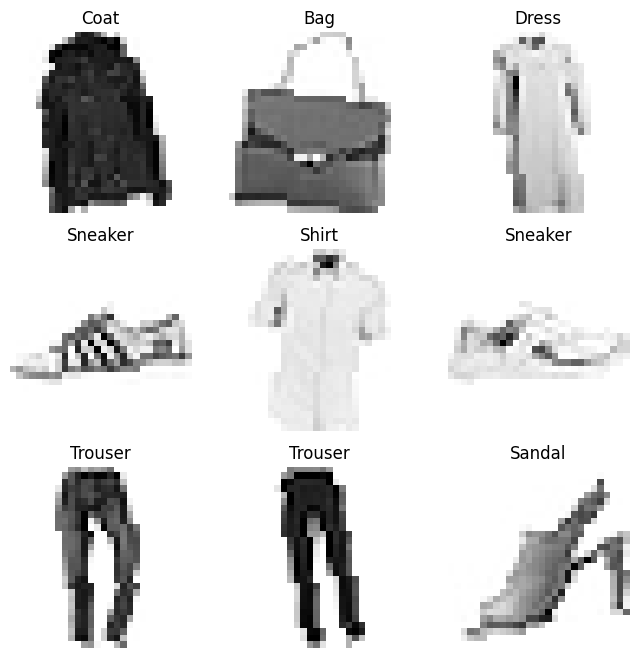

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="Grays")
plt.show()

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.Conv2d(6, 16, 5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Flatten(),
            nn.Linear(16*4*4, 120),
            nn.ReLU(),
            nn.BatchNorm1d(120),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.BatchNorm1d(84),
            nn.Linear(84, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

In [5]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 8, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Flatten(),
            nn.Linear(16*7*7, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

In [44]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 8, 3, 1, 2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, 3, 1, 2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Flatten(),
            nn.Linear(32*4*4, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

In [7]:
class NetworkTrainer:
    def __init__(self, model: nn.Module, 
                 loss_fn: nn.modules.loss._Loss, 
                 optimiser: optim.Optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimiser = optimiser

    def train_model(self, epochs):
        train_loss_list = []
        train_acc_list = []
        test_loss_list = []
        test_acc_list = []
        for epoch in range(epochs):
            print(f'EPOCH {epoch+1}')
            train_loss, train_acc = self._train_epoch()
            test_loss, test_acc = self._eval_epoch()
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            test_loss_list.append(test_loss)
            test_acc_list.append(test_acc)
            print(f'Loss: {train_loss:.3f}, Val_Loss: {test_loss:.3f}')
            print(f'Accuracy: {train_acc:.2f}, Val_Accuracy: {test_acc:.2f}\n')
        return train_loss_list, train_acc_list, test_loss_list, test_acc_list

    def _train_epoch(self):
        self.model.train(True)
        running_loss = 0.0
        correct = 0
        for i, data in enumerate(train_dataloader):
            inputs: torch.Tensor = data[0]
            labels = data[1]
            self.optimiser.zero_grad()
            outputs = self.model(inputs)
            loss: torch.Tensor = self.loss_fn(outputs, labels)
            loss.backward()
            self.optimiser.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
        avg_loss = running_loss / len(train_data)
        accuracy = 100 * correct / len(train_data)
        return avg_loss, accuracy

    def _eval_epoch(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        with torch.no_grad():
            for i, data in enumerate(test_dataloader):
                inputs: torch.Tensor = data[0]
                labels = data[1]
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, labels)
                running_loss += loss * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels)
        avg_loss = running_loss / len(test_data)
        accuracy = 100 * correct / len(test_data)
        return avg_loss, accuracy

In [8]:
def plot_results(results):
    train_loss_list, train_acc_list, test_loss_list, test_acc_list = results

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
    ax1.plot(range(1,11), train_loss_list, label='Train')
    ax1.plot(range(1,11), test_loss_list, label='Test')
    ax1.set_xticks(range(2,11,2))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.plot(range(1,11), train_acc_list, label='Train')
    ax2.plot(range(1,11), test_acc_list, label='Test')
    ax2.set_xticks(range(2,11,2))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    plt.show()

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [10]:
lenet_model = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
lenet_optimiser = optim.Adam(lenet_model.parameters(), lr=0.001, weight_decay=0.0001)

In [11]:
print(lenet_model)

LeNet(
  (conv_stack): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=256, out_features=120, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=120, out_features=84, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Linear(in_features=84, out_features=10, bias=True)
    (16): Softmax(dim=1)
  )
)


In [12]:
lenet_trainer = NetworkTrainer(lenet_model, loss_fn, lenet_optimiser)
lenet_results = lenet_trainer.train_model(10)

EPOCH 1


Loss: 1.684, Val_Loss: 1.632
Accuracy: 78.94, Val_Accuracy: 83.01

EPOCH 2
Loss: 1.623, Val_Loss: 1.610
Accuracy: 84.01, Val_Accuracy: 85.09

EPOCH 3
Loss: 1.611, Val_Loss: 1.598
Accuracy: 85.23, Val_Accuracy: 86.47

EPOCH 4
Loss: 1.603, Val_Loss: 1.594
Accuracy: 85.90, Val_Accuracy: 86.74

EPOCH 5
Loss: 1.598, Val_Loss: 1.594
Accuracy: 86.46, Val_Accuracy: 86.81

EPOCH 6
Loss: 1.595, Val_Loss: 1.586
Accuracy: 86.71, Val_Accuracy: 87.60

EPOCH 7
Loss: 1.593, Val_Loss: 1.601
Accuracy: 86.91, Val_Accuracy: 86.10

EPOCH 8
Loss: 1.590, Val_Loss: 1.590
Accuracy: 87.24, Val_Accuracy: 87.14

EPOCH 9
Loss: 1.586, Val_Loss: 1.587
Accuracy: 87.64, Val_Accuracy: 87.49

EPOCH 10
Loss: 1.585, Val_Loss: 1.578
Accuracy: 87.66, Val_Accuracy: 88.35



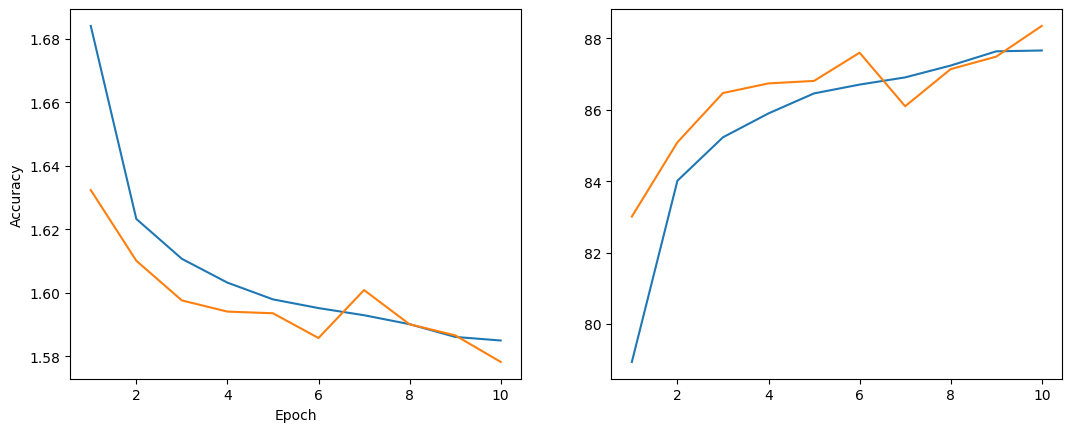

In [13]:
plot_results(lenet_results)

In [14]:
vgg_model = VGG().to(device)
loss_fn = nn.CrossEntropyLoss()
vgg_optimiser = optim.Adam(vgg_model.parameters(), lr=0.001, weight_decay=0.0001)

In [15]:
print(vgg_model)

VGG(
  (conv_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU()
    (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=784, out_f

In [16]:
vgg_trainer = NetworkTrainer(vgg_model, loss_fn, vgg_optimiser)
vgg_results = vgg_trainer.train_model(10)

EPOCH 1


Loss: 1.647, Val_Loss: 1.615
Accuracy: 82.36, Val_Accuracy: 84.71

EPOCH 2
Loss: 1.604, Val_Loss: 1.600
Accuracy: 85.86, Val_Accuracy: 86.20

EPOCH 3
Loss: 1.590, Val_Loss: 1.599
Accuracy: 87.36, Val_Accuracy: 86.33

EPOCH 4
Loss: 1.583, Val_Loss: 1.581
Accuracy: 87.96, Val_Accuracy: 88.14

EPOCH 5
Loss: 1.575, Val_Loss: 1.570
Accuracy: 88.74, Val_Accuracy: 89.18

EPOCH 6
Loss: 1.572, Val_Loss: 1.567
Accuracy: 89.04, Val_Accuracy: 89.41

EPOCH 7
Loss: 1.568, Val_Loss: 1.564
Accuracy: 89.39, Val_Accuracy: 89.68

EPOCH 8
Loss: 1.566, Val_Loss: 1.566
Accuracy: 89.57, Val_Accuracy: 89.57

EPOCH 9
Loss: 1.565, Val_Loss: 1.561
Accuracy: 89.72, Val_Accuracy: 90.03

EPOCH 10
Loss: 1.562, Val_Loss: 1.565
Accuracy: 89.99, Val_Accuracy: 89.70



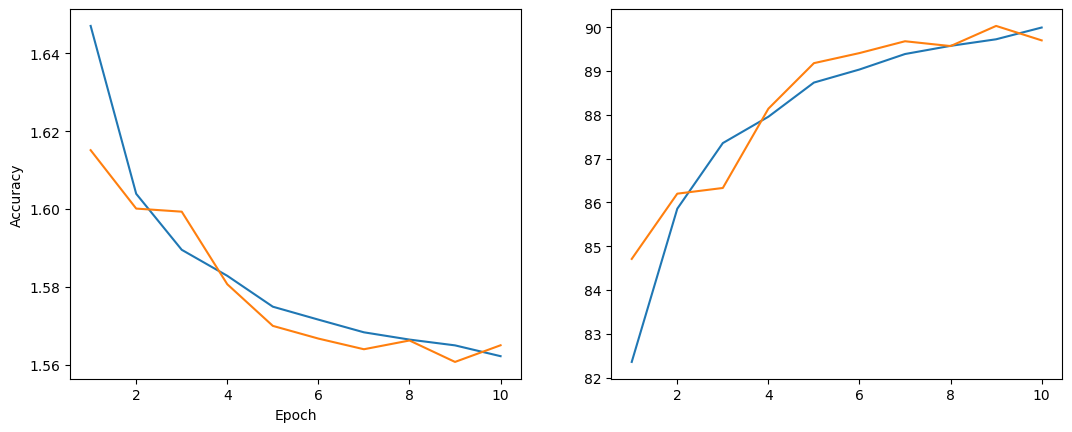

In [17]:
plot_results(vgg_results)

In [45]:
nn_model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
nn_optimiser = optim.Adam(nn_model.parameters(), lr=0.001, weight_decay=0.0001)

In [46]:
print(nn_model)

NeuralNetwork(
  (conv_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU()
    (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [47]:
nn_trainer = NetworkTrainer(nn_model, loss_fn, nn_optimiser)
nn_results = nn_trainer.train_model(10)

EPOCH 1
Loss: 1.676, Val_Loss: 1.636
Accuracy: 79.26, Val_Accuracy: 82.46

EPOCH 2
Loss: 1.622, Val_Loss: 1.609
Accuracy: 84.03, Val_Accuracy: 85.29

EPOCH 3
Loss: 1.605, Val_Loss: 1.595
Accuracy: 85.70, Val_Accuracy: 86.72

EPOCH 4
Loss: 1.593, Val_Loss: 1.592
Accuracy: 86.90, Val_Accuracy: 86.94

EPOCH 5
Loss: 1.588, Val_Loss: 1.592
Accuracy: 87.43, Val_Accuracy: 86.94

EPOCH 6
Loss: 1.583, Val_Loss: 1.577
Accuracy: 87.88, Val_Accuracy: 88.43

EPOCH 7
Loss: 1.579, Val_Loss: 1.578
Accuracy: 88.32, Val_Accuracy: 88.34

EPOCH 8
Loss: 1.575, Val_Loss: 1.573
Accuracy: 88.68, Val_Accuracy: 88.84

EPOCH 9
Loss: 1.575, Val_Loss: 1.571
Accuracy: 88.68, Val_Accuracy: 89.07

EPOCH 10
Loss: 1.571, Val_Loss: 1.569
Accuracy: 89.04, Val_Accuracy: 89.18

